In [3]:
pip install -U tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 6.8 MB/s eta 0:00:00


In [4]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# Prepare the data


In [5]:
CSV_HEADER = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education_num",
    "marital_status",
    "occupation",
    "relationship",
    "race",
    "gender",
    "capital_gain",
    "capital_loss",
    "hours_per_week",
    "native_country",
    "income_bracket",
]

train_data_url = (
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
)
train_data = pd.read_csv(train_data_url, header=None, names=CSV_HEADER)

test_data_url = (
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"
)
test_data = pd.read_csv(test_data_url, header=None, names=CSV_HEADER)

print(f"Train dataset shape: {train_data.shape}")
print(f"Test dataset shape: {test_data.shape}")

Train dataset shape: (32561, 15)
Test dataset shape: (16282, 15)


In [6]:
train_data

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [7]:
test_data = test_data[1:]
test_data.income_bracket = test_data.income_bracket.apply(
    lambda value: value.replace(".", "")
)

<ipython-input-7-830e6b693ac9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.income_bracket = test_data.income_bracket.apply(


In [14]:
train_data_file = "train_data.csv"
test_data_file = "test_data.csv"

train_data.to_csv(train_data_file, index=False, header=False)
test_data.to_csv(test_data_file, index=False, header=False)

# Define dataset metadata


In [9]:
# A list of the numerical feature names.
NUMERIC_FEATURE_NAMES = [
    "age",
    "education_num",
    "capital_gain",
    "capital_loss",
    "hours_per_week",
]
# A dictionary of the categorical features and their vocabulary.
CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "workclass": sorted(list(train_data["workclass"].unique())),
    "education": sorted(list(train_data["education"].unique())),
    "marital_status": sorted(list(train_data["marital_status"].unique())),
    "occupation": sorted(list(train_data["occupation"].unique())),
    "relationship": sorted(list(train_data["relationship"].unique())),
    "race": sorted(list(train_data["race"].unique())),
    "gender": sorted(list(train_data["gender"].unique())),
    "native_country": sorted(list(train_data["native_country"].unique())),
}
# Name of the column to be used as instances weight.
WEIGHT_COLUMN_NAME = "fnlwgt"
# A list of the categorical feature names.
CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())
# A list of all the input features.
FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES
# A list of column default values for each feature.
COLUMN_DEFAULTS = [
    [0.0] if feature_name in NUMERIC_FEATURE_NAMES + [WEIGHT_COLUMN_NAME] else ["NA"]
    for feature_name in CSV_HEADER
]
# The name of the target feature.
TARGET_FEATURE_NAME = "income_bracket"
# A list of the labels of the target features.
TARGET_LABELS = [" <=50K", " >50K"]

# Configure the hyperparameters


In [11]:
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
DROPOUT_RATE = 0.2
BATCH_SIZE = 265
NUM_EPOCHS = 15

NUM_TRANSFORMER_BLOCKS = 3  # Number of transformer blocks.
NUM_HEADS = 4  # Number of attention heads.
EMBEDDING_DIMS = 16  # Embedding dimensions of the categorical features.
MLP_HIDDEN_UNITS_FACTORS = [
    2,
    1,
]  # MLP hidden layer units, as factors of the number of inputs.
NUM_MLP_BLOCKS = 2  # Number of MLP blocks in the baseline model.

# Implement data reading pipeline


In [12]:
target_label_lookup = layers.StringLookup(
    vocabulary=TARGET_LABELS, mask_token=None, num_oov_indices=0
)


def prepare_example(features, target):
    target_index = target_label_lookup(target)
    weights = features.pop(WEIGHT_COLUMN_NAME)
    return features, target_index, weights


def get_dataset_from_csv(csv_file_path, batch_size=128, shuffle=False):
    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=CSV_HEADER,
        column_defaults=COLUMN_DEFAULTS,
        label_name=TARGET_FEATURE_NAME,
        num_epochs=1,
        header=False,
        na_value="?",
        shuffle=shuffle,
    ).map(prepare_example, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
    return dataset.cache()

/usr/local/lib/python3.10/dist-packages/numpy/core/numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


# Implement a training and evaluation procedure

In [15]:
def run_experiment(
    model,
    train_data_file,
    test_data_file,
    num_epochs,
    learning_rate,
    weight_decay,
    batch_size,
):

    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[keras.metrics.BinaryAccuracy(name="accuracy")],
    )

    train_dataset = get_dataset_from_csv(train_data_file, batch_size, shuffle=True)
    validation_dataset = get_dataset_from_csv(test_data_file, batch_size)

    print("Start training the model...")
    history = model.fit(
        train_dataset, epochs=num_epochs, validation_data=validation_dataset
    )
    print("Model training finished")

    _, accuracy = model.evaluate(validation_dataset, verbose=0)

    print(f"Validation accuracy: {round(accuracy * 100, 2)}%")

    return history

# Create model inputs

In [16]:
def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
    return inputs

# Encode features

In [17]:
def encode_inputs(inputs, embedding_dims):

    encoded_categorical_feature_list = []
    numerical_feature_list = []

    for feature_name in inputs:
        if feature_name in CATEGORICAL_FEATURE_NAMES:

            # Get the vocabulary of the categorical feature.
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]

            # Create a lookup to convert string values to an integer indices.
            # Since we are not using a mask token nor expecting any out of vocabulary
            # (oov) token, we set mask_token to None and  num_oov_indices to 0.
            lookup = layers.StringLookup(
                vocabulary=vocabulary,
                mask_token=None,
                num_oov_indices=0,
                output_mode="int",
            )

            # Convert the string input values into integer indices.
            encoded_feature = lookup(inputs[feature_name])

            # Create an embedding layer with the specified dimensions.
            embedding = layers.Embedding(
                input_dim=len(vocabulary), output_dim=embedding_dims
            )

            # Convert the index values to embedding representations.
            encoded_categorical_feature = embedding(encoded_feature)
            encoded_categorical_feature_list.append(encoded_categorical_feature)

        else:

            # Use the numerical features as-is.
            numerical_feature = tf.expand_dims(inputs[feature_name], -1)
            numerical_feature_list.append(numerical_feature)

    return encoded_categorical_feature_list, numerical_feature_list

# Implement an MLP block

In [18]:
def create_mlp(hidden_units, dropout_rate, activation, normalization_layer, name=None):

    mlp_layers = []
    for units in hidden_units:
        mlp_layers.append(normalization_layer),
        mlp_layers.append(layers.Dense(units, activation=activation))
        mlp_layers.append(layers.Dropout(dropout_rate))

    return keras.Sequential(mlp_layers, name=name)

# Experiment 1: a baseline model

Total model weights: 109629


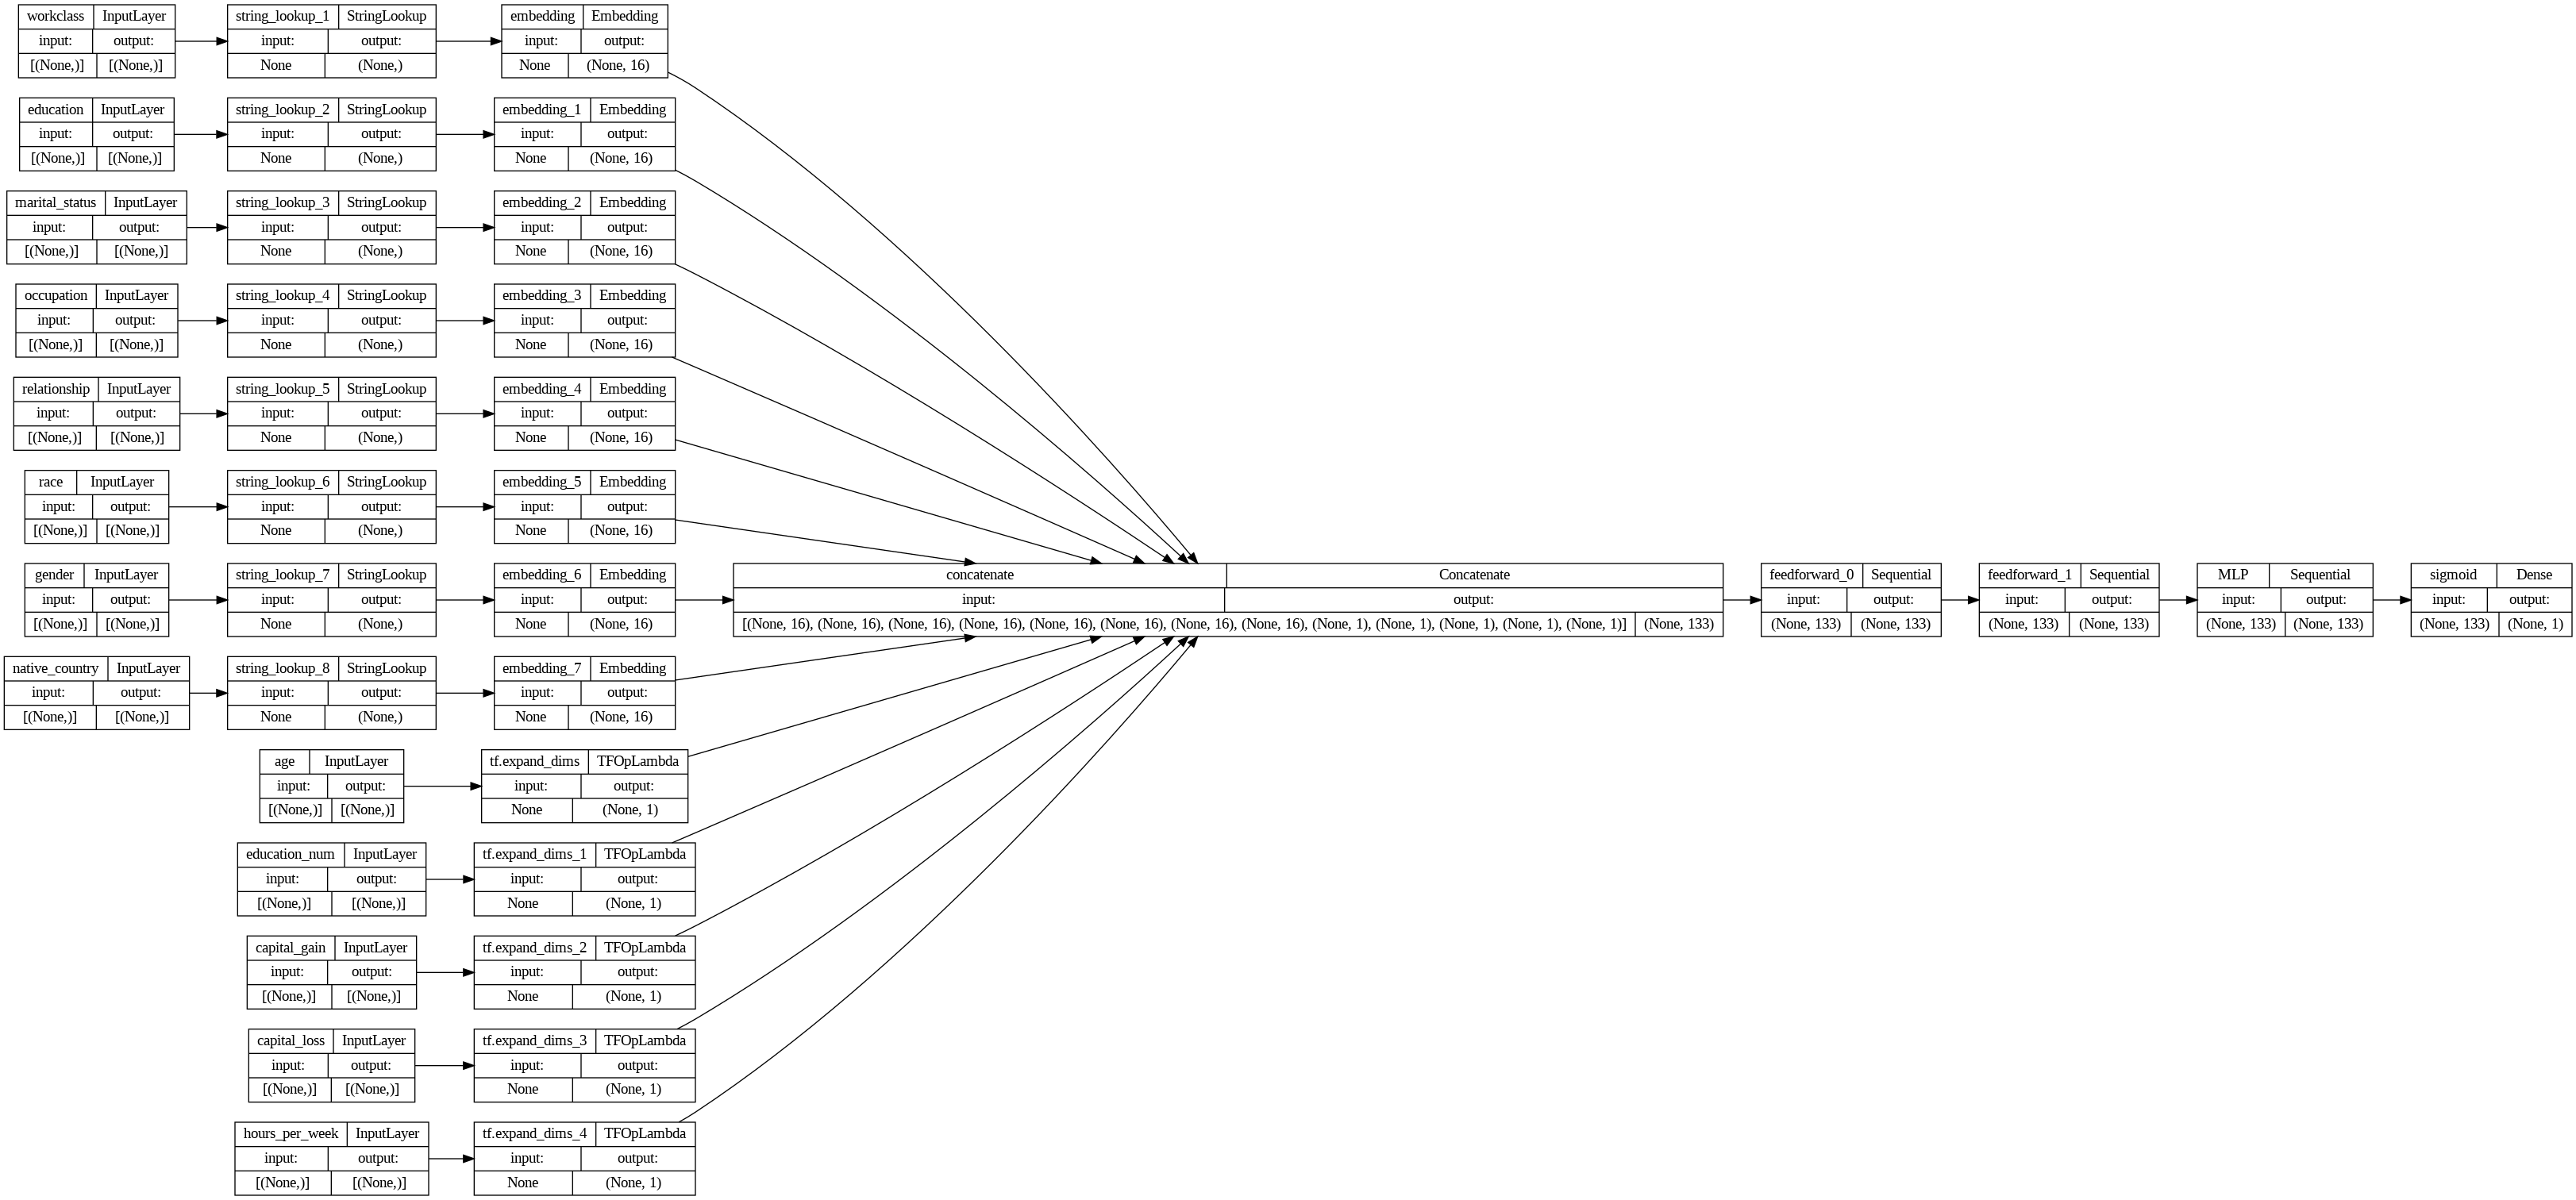

In [19]:
def create_baseline_model(
    embedding_dims, num_mlp_blocks, mlp_hidden_units_factors, dropout_rate
):

    # Create model inputs.
    inputs = create_model_inputs()
    # encode features.
    encoded_categorical_feature_list, numerical_feature_list = encode_inputs(
        inputs, embedding_dims
    )
    # Concatenate all features.
    features = layers.concatenate(
        encoded_categorical_feature_list + numerical_feature_list
    )
    # Compute Feedforward layer units.
    feedforward_units = [features.shape[-1]]

    # Create several feedforwad layers with skip connections.
    for layer_idx in range(num_mlp_blocks):
        features = create_mlp(
            hidden_units=feedforward_units,
            dropout_rate=dropout_rate,
            activation=keras.activations.gelu,
            normalization_layer=layers.LayerNormalization(epsilon=1e-6),
            name=f"feedforward_{layer_idx}",
        )(features)

    # Compute MLP hidden_units.
    mlp_hidden_units = [
        factor * features.shape[-1] for factor in mlp_hidden_units_factors
    ]
    # Create final MLP.
    features = create_mlp(
        hidden_units=mlp_hidden_units,
        dropout_rate=dropout_rate,
        activation=keras.activations.selu,
        normalization_layer=layers.BatchNormalization(),
        name="MLP",
    )(features)

    # Add a sigmoid as a binary classifer.
    outputs = layers.Dense(units=1, activation="sigmoid", name="sigmoid")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


baseline_model = create_baseline_model(
    embedding_dims=EMBEDDING_DIMS,
    num_mlp_blocks=NUM_MLP_BLOCKS,
    mlp_hidden_units_factors=MLP_HIDDEN_UNITS_FACTORS,
    dropout_rate=DROPOUT_RATE,
)

print("Total model weights:", baseline_model.count_params())
keras.utils.plot_model(baseline_model, show_shapes=True, rankdir="LR")

In [20]:
history = run_experiment(
    model=baseline_model,
    train_data_file=train_data_file,
    test_data_file=test_data_file,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    batch_size=BATCH_SIZE,
)

Start training the model...
Epoch 1/15
    123/Unknown - 7s 27ms/step - loss: 110870.8594 - accuracy: 0.7449

123/123 [==============================] - 9s 43ms/step - loss: 110870.8594 - accuracy: 0.7449 - val_loss: 97125.2031 - val_accuracy: 0.7812
Epoch 2/15
121/123 [============================>.] - ETA: 0s - loss: 94818.0312 - accuracy: 0.7679

123/123 [==============================] - 3s 24ms/step - loss: 94569.7812 - accuracy: 0.7690 - val_loss: 99239.2578 - val_accuracy: 0.7810
Epoch 3/15
123/123 [==============================] - ETA: 0s - loss: 76540.6953 - accuracy: 0.7909

123/123 [==============================] - 3s 25ms/step - loss: 76540.6953 - accuracy: 0.7909 - val_loss: 72604.3281 - val_accuracy: 0.8117
Epoch 4/15
122/123 [============================>.] - ETA: 0s - loss: 72552.0469 - accuracy: 0.8011

123/123 [==============================] - 3s 26ms/step - loss: 72503.2500 - accuracy: 0.8011 - val_loss: 67973.1719 - val_accuracy: 0.8194
Epoch 5/15
122/123 [============================>.] - ETA: 0s - loss: 70736.2422 - accuracy: 0.8068

123/123 [==============================] - 3s 22ms/step - loss: 70678.6797 - accuracy: 0.8072 - val_loss: 68056.7031 - val_accuracy: 0.8206
Epoch 6/15
122/123 [============================>.] - ETA: 0s - loss: 69077.7188 - accuracy: 0.8092

123/123 [==============================] - 3s 23ms/step - loss: 69008.7969 - accuracy: 0.8095 - val_loss: 68351.6797 - val_accuracy: 0.8233
Epoch 7/15
123/123 [==============================] - ETA: 0s - loss: 68780.6719 - accuracy: 0.8106

123/123 [==============================] - 4s 31ms/step - loss: 68780.6719 - accuracy: 0.8106 - val_loss: 65808.4922 - val_accuracy: 0.8173
Epoch 8/15
123/123 [==============================] - ETA: 0s - loss: 68053.7578 - accuracy: 0.8136

123/123 [==============================] - 4s 30ms/step - loss: 68053.7578 - accuracy: 0.8136 - val_loss: 66285.6641 - val_accuracy: 0.8217
Epoch 9/15
122/123 [============================>.] - ETA: 0s - loss: 67375.5469 - accuracy: 0.8164

123/123 [==============================] - 3s 25ms/step - loss: 67306.5703 - accuracy: 0.8166 - val_loss: 65378.4375 - val_accuracy: 0.8175
Epoch 10/15
123/123 [==============================] - ETA: 0s - loss: 67150.3203 - accuracy: 0.8167

123/123 [==============================] - 4s 34ms/step - loss: 67150.3203 - accuracy: 0.8167 - val_loss: 66192.0469 - val_accuracy: 0.8228
Epoch 11/15
123/123 [==============================] - ETA: 0s - loss: 66906.9062 - accuracy: 0.8165

123/123 [==============================] - 3s 23ms/step - loss: 66906.9062 - accuracy: 0.8165 - val_loss: 64665.9141 - val_accuracy: 0.8208
Epoch 12/15
121/123 [============================>.] - ETA: 0s - loss: 65644.1016 - accuracy: 0.8217

123/123 [==============================] - 3s 25ms/step - loss: 65668.6484 - accuracy: 0.8221 - val_loss: 63577.3320 - val_accuracy: 0.8304
Epoch 13/15
123/123 [==============================] - ETA: 0s - loss: 63861.7227 - accuracy: 0.8323

123/123 [==============================] - 4s 33ms/step - loss: 63861.7227 - accuracy: 0.8323 - val_loss: 62332.2656 - val_accuracy: 0.8332
Epoch 14/15
123/123 [==============================] - ETA: 0s - loss: 62853.7930 - accuracy: 0.8341

123/123 [==============================] - 3s 23ms/step - loss: 62853.7930 - accuracy: 0.8341 - val_loss: 63304.9219 - val_accuracy: 0.8290
Epoch 15/15
122/123 [============================>.] - ETA: 0s - loss: 62643.0664 - accuracy: 0.8317

123/123 [==============================] - 3s 23ms/step - loss: 62571.0273 - accuracy: 0.8320 - val_loss: 64941.3516 - val_accuracy: 0.8299


Model training finished
Validation accuracy: 82.99%


Total model weights: 87479


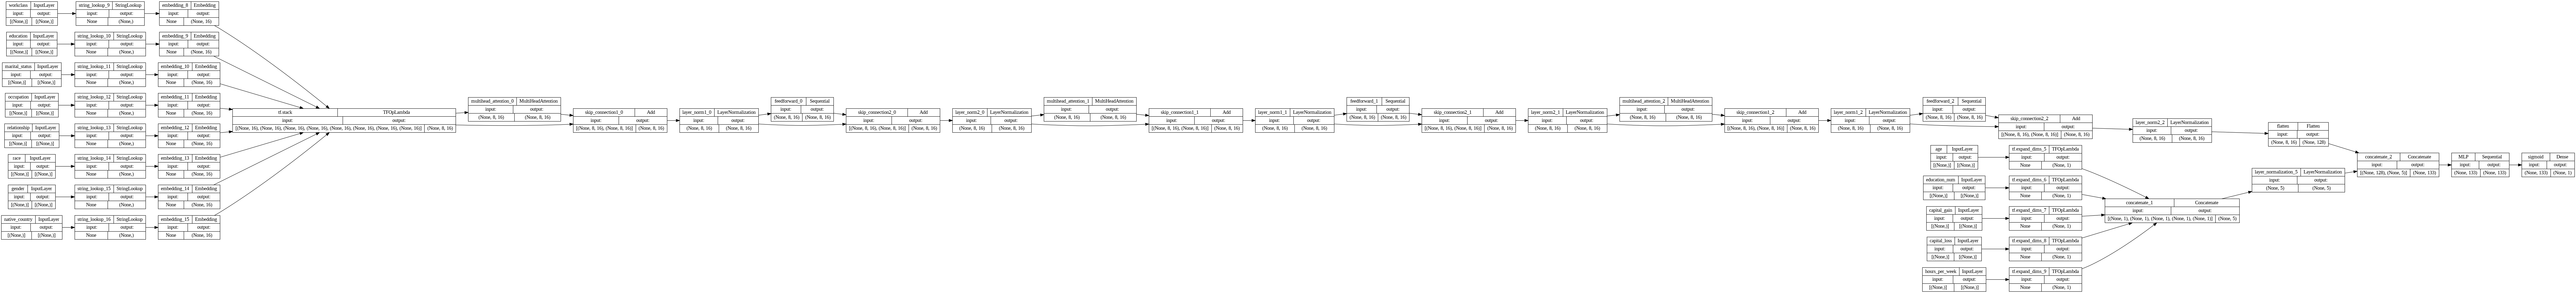

In [21]:
def create_tabtransformer_classifier(
    num_transformer_blocks,
    num_heads,
    embedding_dims,
    mlp_hidden_units_factors,
    dropout_rate,
    use_column_embedding=False,
):

    # Create model inputs.
    inputs = create_model_inputs()
    # encode features.
    encoded_categorical_feature_list, numerical_feature_list = encode_inputs(
        inputs, embedding_dims
    )
    # Stack categorical feature embeddings for the Tansformer.
    encoded_categorical_features = tf.stack(encoded_categorical_feature_list, axis=1)
    # Concatenate numerical features.
    numerical_features = layers.concatenate(numerical_feature_list)

    # Add column embedding to categorical feature embeddings.
    if use_column_embedding:
        num_columns = encoded_categorical_features.shape[1]
        column_embedding = layers.Embedding(
            input_dim=num_columns, output_dim=embedding_dims
        )
        column_indices = tf.range(start=0, limit=num_columns, delta=1)
        encoded_categorical_features = encoded_categorical_features + column_embedding(
            column_indices
        )

    # Create multiple layers of the Transformer block.
    for block_idx in range(num_transformer_blocks):
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dims,
            dropout=dropout_rate,
            name=f"multihead_attention_{block_idx}",
        )(encoded_categorical_features, encoded_categorical_features)
        # Skip connection 1.
        x = layers.Add(name=f"skip_connection1_{block_idx}")(
            [attention_output, encoded_categorical_features]
        )
        # Layer normalization 1.
        x = layers.LayerNormalization(name=f"layer_norm1_{block_idx}", epsilon=1e-6)(x)
        # Feedforward.
        feedforward_output = create_mlp(
            hidden_units=[embedding_dims],
            dropout_rate=dropout_rate,
            activation=keras.activations.gelu,
            normalization_layer=layers.LayerNormalization(epsilon=1e-6),
            name=f"feedforward_{block_idx}",
        )(x)
        # Skip connection 2.
        x = layers.Add(name=f"skip_connection2_{block_idx}")([feedforward_output, x])
        # Layer normalization 2.
        encoded_categorical_features = layers.LayerNormalization(
            name=f"layer_norm2_{block_idx}", epsilon=1e-6
        )(x)

    # Flatten the "contextualized" embeddings of the categorical features.
    categorical_features = layers.Flatten()(encoded_categorical_features)
    # Apply layer normalization to the numerical features.
    numerical_features = layers.LayerNormalization(epsilon=1e-6)(numerical_features)
    # Prepare the input for the final MLP block.
    features = layers.concatenate([categorical_features, numerical_features])

    # Compute MLP hidden_units.
    mlp_hidden_units = [
        factor * features.shape[-1] for factor in mlp_hidden_units_factors
    ]
    # Create final MLP.
    features = create_mlp(
        hidden_units=mlp_hidden_units,
        dropout_rate=dropout_rate,
        activation=keras.activations.selu,
        normalization_layer=layers.BatchNormalization(),
        name="MLP",
    )(features)

    # Add a sigmoid as a binary classifer.
    outputs = layers.Dense(units=1, activation="sigmoid", name="sigmoid")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


tabtransformer_model = create_tabtransformer_classifier(
    num_transformer_blocks=NUM_TRANSFORMER_BLOCKS,
    num_heads=NUM_HEADS,
    embedding_dims=EMBEDDING_DIMS,
    mlp_hidden_units_factors=MLP_HIDDEN_UNITS_FACTORS,
    dropout_rate=DROPOUT_RATE,
)

print("Total model weights:", tabtransformer_model.count_params())
keras.utils.plot_model(tabtransformer_model, show_shapes=True, rankdir="LR")

In [22]:
history = run_experiment(
    model=tabtransformer_model,
    train_data_file=train_data_file,
    test_data_file=test_data_file,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    batch_size=BATCH_SIZE,
)

Start training the model...
Epoch 1/15
    123/Unknown - 19s 82ms/step - loss: 79198.8984 - accuracy: 0.8023

123/123 [==============================] - 21s 101ms/step - loss: 79198.8984 - accuracy: 0.8023 - val_loss: 65499.4648 - val_accuracy: 0.8375
Epoch 2/15
123/123 [==============================] - ETA: 0s - loss: 68940.6172 - accuracy: 0.8252

123/123 [==============================] - 11s 86ms/step - loss: 68940.6172 - accuracy: 0.8252 - val_loss: 64034.7461 - val_accuracy: 0.8397
Epoch 3/15
123/123 [==============================] - ETA: 0s - loss: 66863.1172 - accuracy: 0.8298

123/123 [==============================] - 10s 77ms/step - loss: 66863.1172 - accuracy: 0.8298 - val_loss: 62893.4531 - val_accuracy: 0.8407
Epoch 4/15
123/123 [==============================] - ETA: 0s - loss: 65361.8867 - accuracy: 0.8342

123/123 [==============================] - 10s 82ms/step - loss: 65361.8867 - accuracy: 0.8342 - val_loss: 62074.5820 - val_accuracy: 0.8422
Epoch 5/15
123/123 [==============================] - ETA: 0s - loss: 63869.3086 - accuracy: 0.8365

123/123 [==============================] - 11s 88ms/step - loss: 63869.3086 - accuracy: 0.8365 - val_loss: 61635.3516 - val_accuracy: 0.8448
Epoch 6/15
123/123 [==============================] - ETA: 0s - loss: 63398.2266 - accuracy: 0.8388

123/123 [==============================] - 11s 87ms/step - loss: 63398.2266 - accuracy: 0.8388 - val_loss: 61272.6953 - val_accuracy: 0.8453
Epoch 7/15
123/123 [==============================] - ETA: 0s - loss: 62690.1211 - accuracy: 0.8410

123/123 [==============================] - 12s 95ms/step - loss: 62690.1211 - accuracy: 0.8410 - val_loss: 60893.7227 - val_accuracy: 0.8451
Epoch 8/15
123/123 [==============================] - ETA: 0s - loss: 62426.4062 - accuracy: 0.8405

123/123 [==============================] - 11s 87ms/step - loss: 62426.4062 - accuracy: 0.8405 - val_loss: 61146.6289 - val_accuracy: 0.8438
Epoch 9/15
123/123 [==============================] - ETA: 0s - loss: 62178.6719 - accuracy: 0.8411

123/123 [==============================] - 11s 87ms/step - loss: 62178.6719 - accuracy: 0.8411 - val_loss: 60876.1250 - val_accuracy: 0.8450
Epoch 10/15
123/123 [==============================] - ETA: 0s - loss: 61682.5117 - accuracy: 0.8428

123/123 [==============================] - 11s 89ms/step - loss: 61682.5117 - accuracy: 0.8428 - val_loss: 60978.6641 - val_accuracy: 0.8468
Epoch 11/15
123/123 [==============================] - ETA: 0s - loss: 61510.1211 - accuracy: 0.8434

123/123 [==============================] - 9s 76ms/step - loss: 61510.1211 - accuracy: 0.8434 - val_loss: 60734.6680 - val_accuracy: 0.8461
Epoch 12/15
123/123 [==============================] - ETA: 0s - loss: 61269.9453 - accuracy: 0.8441

123/123 [==============================] - 10s 83ms/step - loss: 61269.9453 - accuracy: 0.8441 - val_loss: 60895.1172 - val_accuracy: 0.8455
Epoch 13/15
123/123 [==============================] - ETA: 0s - loss: 61400.4922 - accuracy: 0.8440

123/123 [==============================] - 11s 87ms/step - loss: 61400.4922 - accuracy: 0.8440 - val_loss: 60938.0781 - val_accuracy: 0.8463
Epoch 14/15
123/123 [==============================] - ETA: 0s - loss: 61115.1992 - accuracy: 0.8447

123/123 [==============================] - 11s 87ms/step - loss: 61115.1992 - accuracy: 0.8447 - val_loss: 60930.8945 - val_accuracy: 0.8463
Epoch 15/15
123/123 [==============================] - ETA: 0s - loss: 60990.0781 - accuracy: 0.8437

123/123 [==============================] - 11s 89ms/step - loss: 60990.0781 - accuracy: 0.8437 - val_loss: 61018.2148 - val_accuracy: 0.8454


Model training finished
Validation accuracy: 84.54%
